# $$ Hyperspectral\ Image\ Classification\ using\ SVM \ and\ RF\ with\ PCA $$

## $$ Methodology $$

$$ 1.\ Hyperspectral\ Image\ acqusition\ $$
$$ 2.\ Pre-processing $$
$$ 3.\ Spectral\ and\ Spatial\ feature\ selection\ and\ extraction$$
$$ 4.\ Classification $$
$$ 5.\ Performance\ Evalution $$

## $$ Accuracy\ Results $$
|MODEL |TOTAL ACCURACY|
|------|--------------|
|SVM   |85.12%        |     
|RF    |87.85         |
|SVM + PCA|92.04%     |
|RF + PCA |81.05%     |

In [ ]:
#Importinf required libraries

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from scipy.ndimage import convolve

import seaborn as sn

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from PIL import Image

## Importing the Indian Pines dataset

In [2]:
from scipy.io import loadmat

indian_pines = loadmat('Indian_pines_corrected.mat')
indian_pines.keys()

dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])

In [3]:
hsi = indian_pines['indian_pines_corrected']
hsi.shape

(145, 145, 200)

### Normalize the Dataset

In [4]:
from sklearn.preprocessing import StandardScaler

#Noormalizing the Dataset using Standard scaler
X = hsi.reshape(-1, hsi.shape[2])
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
X_normalized.shape

(21025, 200)

In [5]:
#Reshaping 2D into 3D dataset
norm_data = X_normalized.reshape(145, 145, 200)
norm_data.shape

(145, 145, 200)

## Visualizing Ground Truth

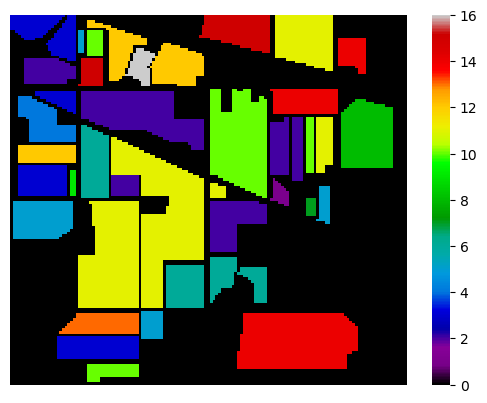

In [6]:
indian_pines_gt = loadmat('Indian_pines_gt.mat')
indian_pines_gt.keys()

gt = indian_pines_gt['indian_pines_gt']

sn.heatmap(gt, cmap='nipy_spectral')
plt.axis('off')
plt.show()

### Extracting the Pixel values from the dataset

In [7]:
def extract_pixels(hsi, gt):
  q = hsi.reshape(-1, hsi.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = gt.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+hsi.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(hsi, gt)

print('Shape of df:', df.shape)
df.head()

Shape of df: (21025, 201)


,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


## Visualizing the Spectral Signatures (before Normalizing)

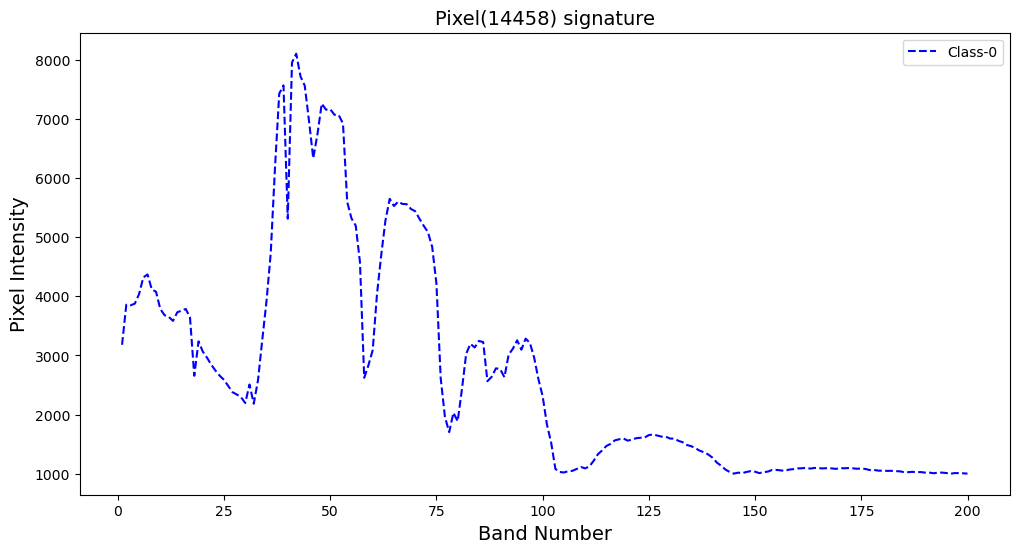

In [8]:
def plot_signature(df):
    plt.figure(figsize=(12, 6)) 
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 201), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label=f'Class-{df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize = 14)
    plt.xlabel('Band Number', fontsize = 14)
    plt.ylabel('Pixel Intensity', fontsize = 14)
    plt.show()
plot_signature(df)

## Box Plot with respect to bands of the HSI

Enter the band number (1-200):4


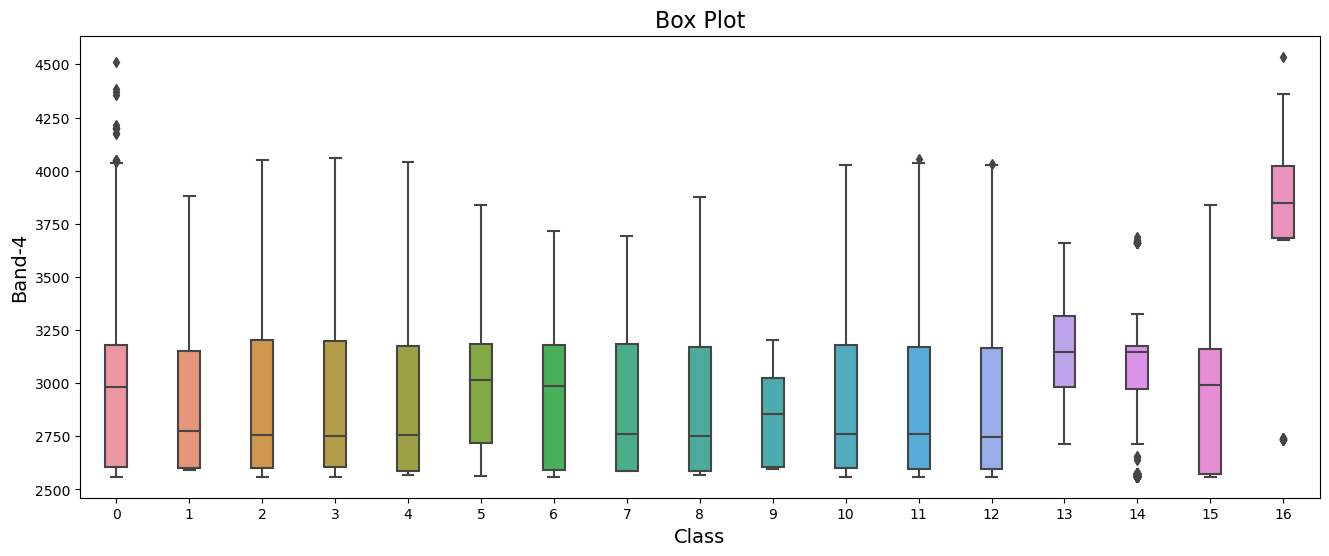

In [9]:
#Box Plot

plt.figure(figsize = (16,6))
n = int(input('Enter the band number (1-200):'))
sn.boxplot(x=df['class'], y=df['band1'], width=0.3);
plt.title('Box Plot', fontsize = 16)
plt.xlabel('Class', fontsize = 14 )
plt.ylabel(f'Band-{n}', fontsize=14)
plt.show()

# $$Pricipal\ Compenent\ Analysis$$ 
(Craig Rodarmel and Jie Shan)

The principal component analysis is based on the fact that neighboring bands of hyperspectral images are highly correlated and often convey almost the same information about the object.

The analysis is used to transform the original data so to remove the correlation among the bands. 

In the process, the optimum linear combination of the original bands accounting for the variation of pixel values in an image is identified. 

An Image pixel vector is calculated as 

$$X_{i} = [x_{1}, x_{2}, .....x){N}]_{i}^{T} $$

with all pixel values $ x_{1}, x_{2},...x_{N} $ at one corresponding pixel location of the hyperspectral image data.

The dimension of that image vector is equal to the number of hyperspectral bands $N$.

For a hyperspectral image with $m$ rows and $n$ columns there will be $M=m*n$ such vectors, namely $i=1,…,M$. The mean vector of all image vectors is denoted and calculated as:

$$ m = \frac{1}{M}\sum_{i\in M}[x_{1} x_{2} .. .. x_{N}]^{T}	 $$

The covaraince matrix of $x$ is defined as:

$$ Cov(x) = E(x-E(x))(x-E(x))^{T} $$

where: $E$ = expectation operator; $T$ superscript = transpose operation; and
Cov = notation for covariance matrix.

The covariance matrix is approximated via the following calculation:

$$ C_{x} = \frac{1}{M}\sum_{i\in M}(x_{i} - m)(x_{i} - m)^{T} $$


The PCA is based on the eigenvalue decomposition of the covariance matrix, which takes the form of:

$$
c_{x} = ADA^{T}
$$

where: $D = diag(\lambda_{1},\lambda_{2},...\lambda_{N})$ is the diagonal matrix composed of the eigenvalues $\lambda_{1},\lambda_{2},...\lambda_{N}$ of the covariance matrix $C_{x}$ , and $A$ is the orthogonal matrix compon=sed of the corresponding N dimension eigenvectors $a_{k}(k=1,2,....,N)$ of $C_{x}$ as follows:

$$ A = (a_{1}, a_{2}, ....,a_{N})$$



The linear transformation defined by:

$$
y_{i} = A^{T}x_{i} (I = 1, 2, ..., M)
$$

is the PCA pixel vector, all these pixel vectors form the PCA (transformed) abnds of the original images.

(-0.5, 446.5, 655.5, -0.5)

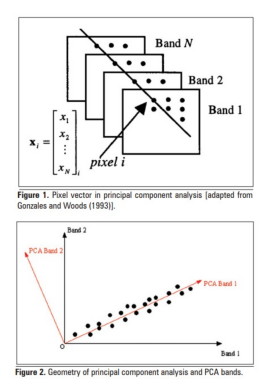

In [11]:
img = Image.open('PCA_Image.jpg')
plt.imshow(img)
plt.axis('off')

### $Plotting\ Signal\ vs\ Noise\ Curves$

In [13]:
def conduct_pca(hsi):
    # Reshape hyperspectral image data for PCA
    hsi_reshape = hsi.reshape(-1, hsi.shape[2])
    
    # Perform PCA
    pca = PCA(n_components = hsi.shape[2])
    pcs = pca.fit_transform(hsi_reshape)
    
    return pcs, pca

conduct_pca(hsi)

(array([[ 5.01490598e+03,  1.45686326e+03,  7.26970489e+01, ...,
          2.23023032e+00, -4.64113929e+00,  3.04609980e+00],
        [ 5.60138374e+03, -2.02345009e+03,  3.50134661e+02, ...,
         -5.07161369e-01,  3.38037811e-01,  3.47220575e+00],
        [ 5.79613544e+03, -3.09039485e+03,  4.90539929e+02, ...,
          2.81767396e+00, -2.25685353e+00,  4.83530026e+00],
        ...,
        [-7.36983420e+03, -1.13238177e+03,  3.98170226e+02, ...,
          3.09152096e+00,  2.25293413e+00,  2.18059685e+00],
        [-6.49708724e+03,  7.98240033e+02,  6.76808968e+02, ...,
         -2.62198593e+00,  3.57848647e+00,  4.55291628e-01],
        [-6.57046116e+03,  3.46749622e+02,  4.65450797e+02, ...,
         -1.08123324e+01,  6.36503536e+00,  1.10574156e+00]]),
 PCA(n_components=200))

In [14]:
def smooth_pc_maps(pcs, hsi_shape):
    smoothed_pcs = []
    for pc in pcs.T:
        # Reshape PC back to spatial dimensions
        pc_spatial = pc.reshape(hsi_shape[:2])
        # Smooth PC map with 3x3 pixel averaging kernel
        smoothed_pc = convolve(pc_spatial, np.ones((3, 3)) / 9, mode='constant')
        smoothed_pcs.append(smoothed_pc)
    
    return np.array(smoothed_pcs)

In [15]:
def calculate_signal_noise(pcs, smoothed_pcs):
    signals = []
    noises = []
    for pc, smoothed_pc in zip(pcs.T, smoothed_pcs):
        # Calculate signal image
        signal = smoothed_pc
        # Calculate noise image
        noise = pc.reshape(smoothed_pc.shape) - smoothed_pc
        # Calculate standard deviations of signal and noise images
        signals.append(np.std(signal))
        noises.append(np.std(noise))
    
    return signals, noises

In [16]:
def identify_dimensionality(signals, noises):
    # Plot signal and noise curves against PC number
    pcs = np.arange(1, len(signals) + 1)
    plt.figure(figsize=(10,4))
    plt.plot(pcs, signals, label='Signal')
    plt.plot(pcs, noises, label='Noise')
    plt.xlabel('PC Number')
    plt.ylabel('Standard Deviation')
    plt.title('Signal and Noise Curves', fontsize = 16)
    plt.legend()
    plt.grid(True)
    plt.show()

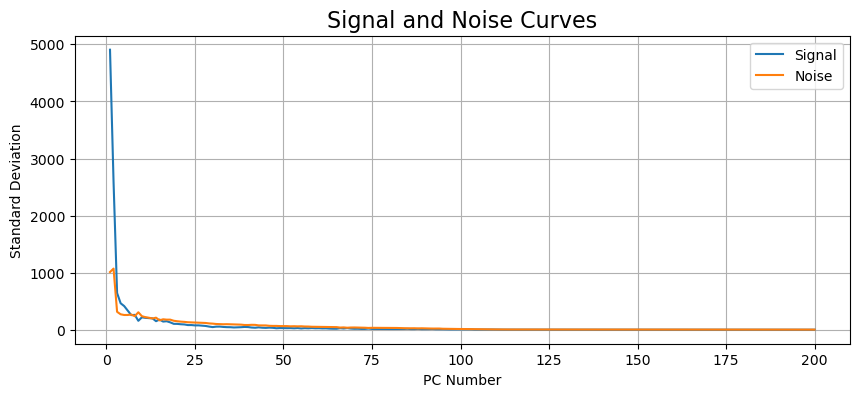

In [17]:
pcs, pca_model = conduct_pca(hsi)
smoothed_pcs = smooth_pc_maps(pcs, hsi.shape)
signals, noises = calculate_signal_noise(pcs, smoothed_pcs)
identify_dimensionality(signals, noises)

### Plotting Cumulative explained variance

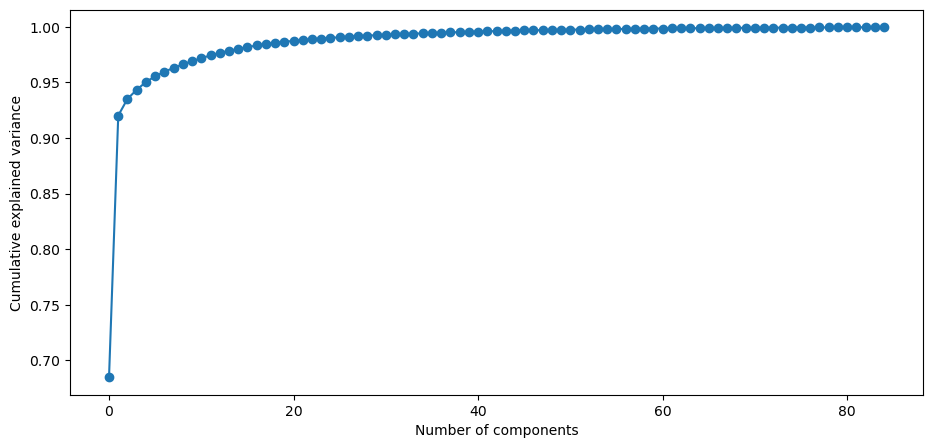

In [18]:
pca = PCA(n_components = 85)
principalComponents = pca.fit_transform(df.iloc[:, :-1].values)
ev = pca.explained_variance_ratio_

plt.figure(figsize=(11, 5))
plt.plot(np.cumsum(ev), marker = 'o', linestyle = '-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Plotting the PC Bands

In [19]:
#Performing PCA
pca = PCA(n_components = 150)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = gt.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,151)]+['class']
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-142,PC-143,PC-144,PC-145,PC-146,PC-147,PC-148,PC-149,PC-150,class
0,5014.905985,1456.863260,72.697049,71.204926,-435.686985,-68.840318,134.809864,-304.372455,256.432994,-66.630999,...,0.184829,4.100303,3.205856,-12.941078,-4.043657,-2.678046,4.824024,4.806137,0.449691,3
1,5601.383743,-2023.450087,350.134661,-528.465053,148.088296,-288.359031,202.956863,240.848020,-474.857836,93.493771,...,-1.475329,1.391584,1.210918,-8.977376,6.403171,-3.227253,-2.558963,0.920566,2.822637,3
2,5796.135442,-3090.394852,490.539929,-760.214346,259.933303,-131.611181,172.927304,205.911237,572.491978,-191.622014,...,-0.583929,6.393183,6.204584,-4.145236,0.305651,1.358094,5.515666,7.686543,-5.588539,3
3,5586.204575,-2369.376085,356.274719,-502.687155,146.554951,-306.679326,251.071095,234.966433,-314.023248,54.962246,...,2.749391,8.651274,3.625616,-0.301594,0.196996,-0.175597,12.588704,6.723784,1.014372,3
4,5020.990792,339.603390,-23.007525,-92.556769,-368.495443,-438.266709,502.715429,-345.536587,-188.352757,-67.506061,...,4.653773,4.242319,0.794297,-1.402885,7.707780,-6.726687,7.471117,0.388625,-0.605292,3


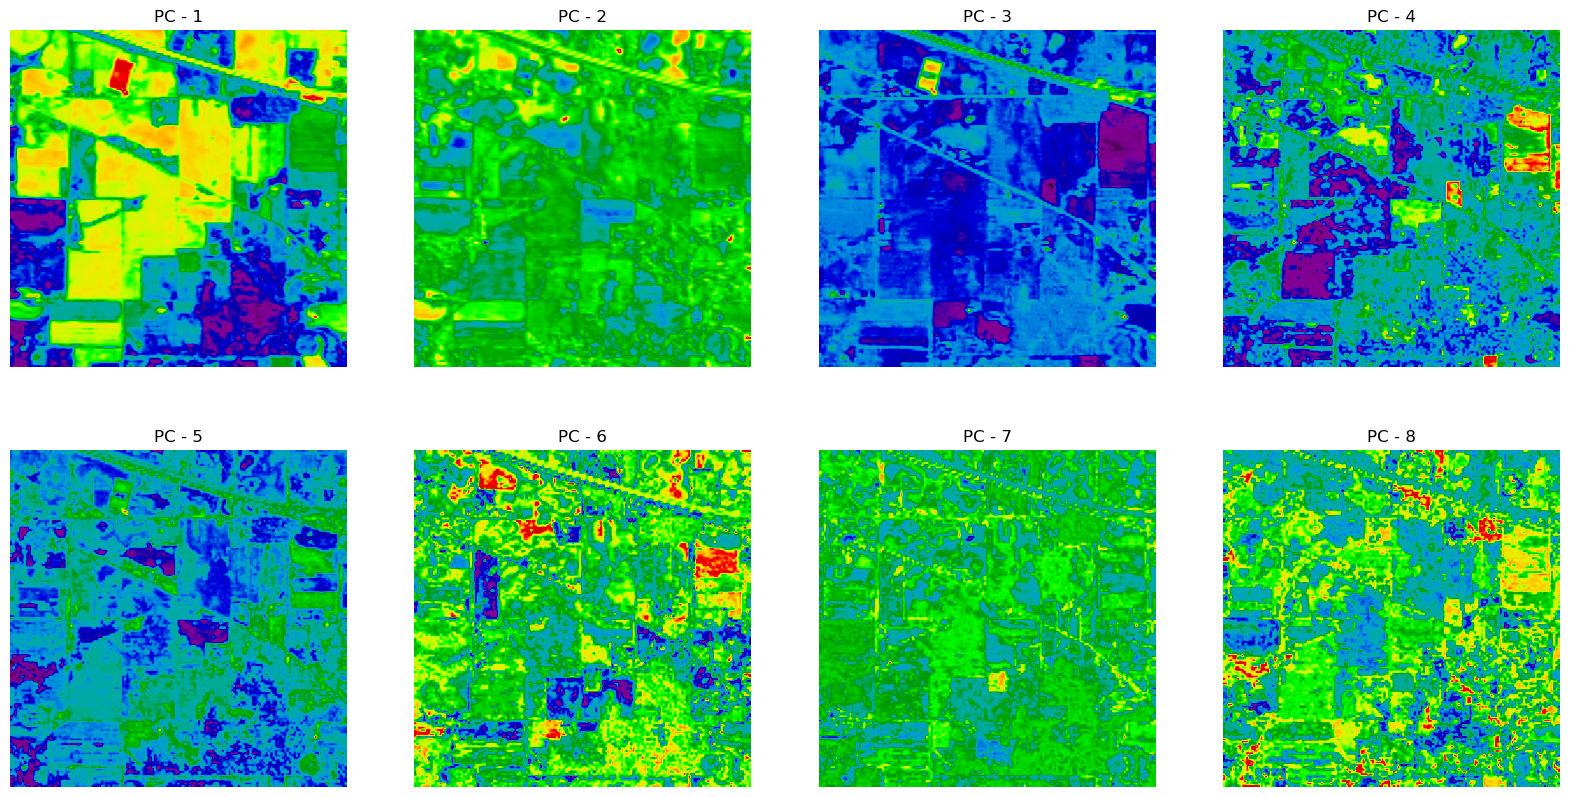

In [20]:
#Plotting 1st 8 PC bands
fig = plt.figure(figsize = (20, 10))

for i in range(1, 9):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'PC - {i}')
plt.show()

### Extracting the Individual Spectra

In [21]:
class_values = q['class'].unique()  # Get unique class labels

# Dictionary to store DataFrame for each class
class_data = {}

for class_label in class_values:
    # Filter DataFrame for each class
    class_df = df[df['class'] == class_label]
    class_data[class_label] = class_df

# class_data dictionary contains DataFrames for each class
class_data.keys()

dict_keys([3, 0, 15, 11, 12, 5, 10, 14, 16, 2, 4, 8, 6, 9, 1, 7, 13])

### Assigning the Class Names

In [22]:
class_name = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees',
               'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
               'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']

# Create a dictionary to store DataFrames with class names as keys
class_data_named = {class_name[i]: class_data[i + 1] for i in range(len(class_name))}

# Concatenate all DataFrames into a single DataFrame
all_data = pd.concat(class_data_named.values())

In [23]:
class_data_named.keys()

dict_keys(['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill', 'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers'])

# $$ Support\ Vector\ Machine\ without\ PCA $$

SVM are supervised learning techniques with related learning calculations fit for performing information order, relapse examination and exception discovery. It likewise performs direct arrangement, and can effectively play out a non-straight order utilizing kernel (Mounika et al, 2021).

SVMs aim to find the optimal hyperplane that seperates different classes in the feature space.

### $Basic\ Idea$
Given a set of labeled training data, where each data point belongs to one of two classes, an SVM finds the hyperplane that best separates the classes while maximizing the margin between the closest data points from each class, known as support vectors.

In instance of nonlinearcases as of HIS Data is nonlinear. So, ordinary SVM technique can't fulfill the prerequisites of grouping.

(-0.5, 656.5, 549.5, -0.5)

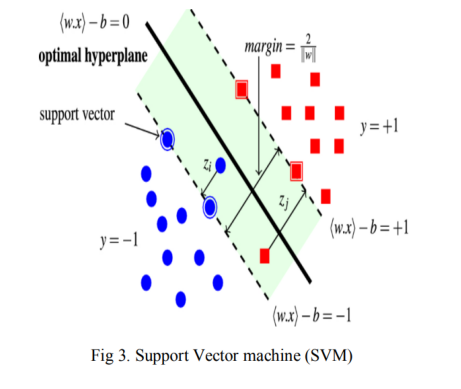

In [24]:
svm = Image.open('SVM_image.png')
plt.imshow(svm)
plt.axis('off')

In [25]:
# Classification of HSI using SVM

In [26]:
# Filter out class 0
x1 = df[df['class'] != 0]

In [56]:
# Defining X and y values for training and testing the dataset
X1 = x1.iloc[:, :-1].values
y1 = x1.loc[:, 'class'].values
X1.shape
y1.shape

(10249,)

In [28]:

# Splitting the training and testing dataset
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=11, stratify=y1)

In [29]:
# SVM using RBF kernel
svm = SVC(C=100, kernel='rbf', cache_size=10*1024)
svm.fit(X1_train, y1_train)
ypred = svm.predict(X1_test)

Overall Accuracy %: 85.1219512195122 %


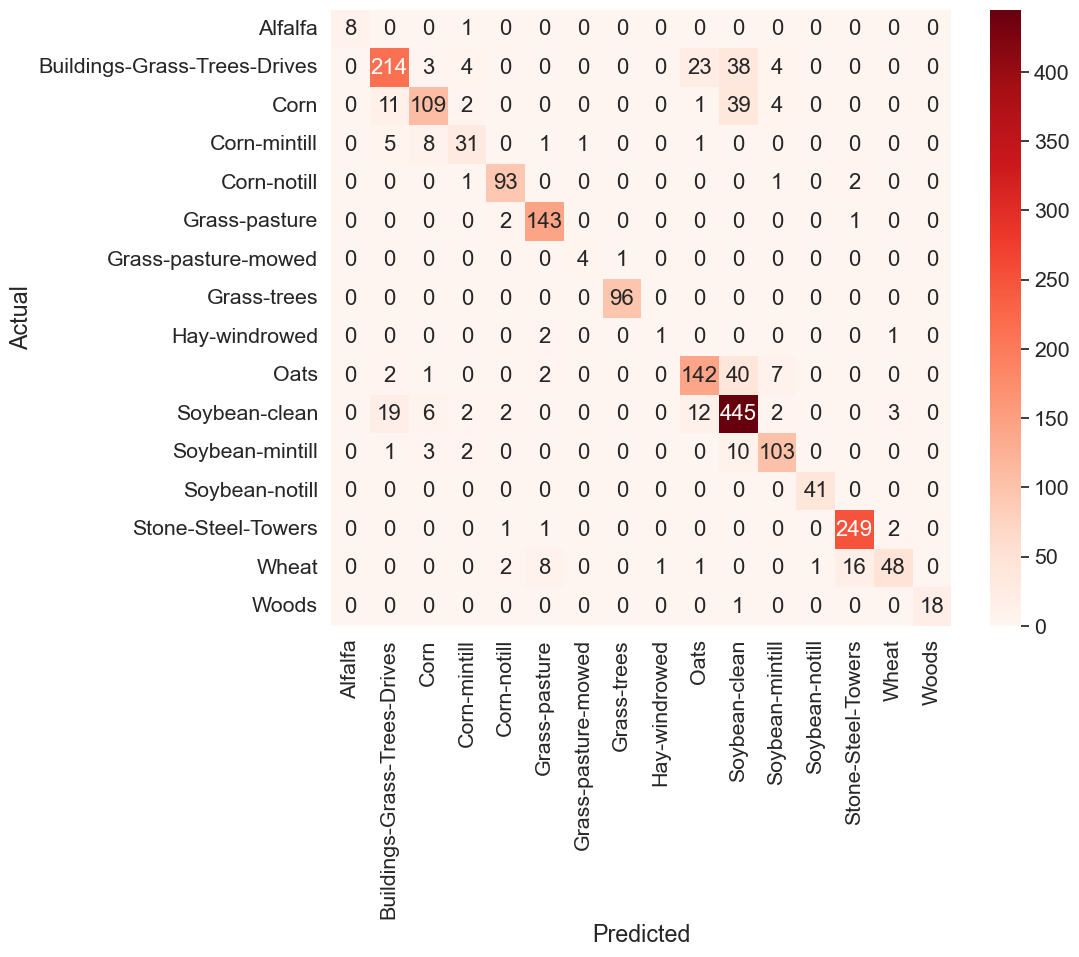

In [30]:
# Generating the Confusion Matrix
data = confusion_matrix(y1_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(class_name), index=np.unique(class_name))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(df_cm, cmap="Reds", annot=True, annot_kws={"size": 16}, fmt='d')

# Calculate overall accuracy
overall_accuracy = accuracy_score(y1_test, ypred)
print("Overall Accuracy %:", overall_accuracy*100, '%')

# Show the plot
plt.show()

### $Confusion\ Matrix$ 
The error matrix or Confusion Matrix compares the ground truth with the classification result

## $Accuracy $

The accuracy defines the difference between the samples predicted values with the original set of given samples.

$$
Accuracy = \frac{T_{P} + T_{N}}{T_{P} + T_{N} + F_{P} + F_{N}}
$$
where:

$T_{P}$: The number of correctly predicted positive instances


$T_{N}$: The number of correctly predicted negative instances


$F_{P}$: The number of incorrectly predicted positive instances (actual negative, predicted positive)


$F_{N}$:  The number of incorrectly predicted negative instances (actual positive, predicted negative).

In [31]:
print(classification_report(y1_test, ypred, target_names = class_name))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.85      0.75      0.80       286
                Corn-mintill       0.84      0.66      0.74       166
                        Corn       0.72      0.66      0.69        47
               Grass-pasture       0.93      0.96      0.94        97
                 Grass-trees       0.91      0.98      0.94       146
         Grass-pasture-mowed       0.80      0.80      0.80         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.50      0.25      0.33         4
              Soybean-notill       0.79      0.73      0.76       194
             Soybean-mintill       0.78      0.91      0.84       491
               Soybean-clean       0.85      0.87      0.86       119
                       Wheat       0.98      1.00      0.99        41
                   

In [32]:
expected_shape = hsi.shape[:2]
t = []
for i in range(df.shape[0]):
    if df.iloc[i, -1] == 0:
        t.append(0)
    else:
        prediction = svm.predict(df.iloc[i, :-1].values.reshape(1, -1))
        # Ensure prediction is a scalar value before appending
        if isinstance(prediction, (int, float)):
            t.append(prediction)
        else:
            t.append(prediction.item())  # Extract scalar value from array

# Now, check if the length of l matches the expected shape
if len(t) != expected_shape[0] * expected_shape[1]:
    print("Error: Total number of elements in the list does not match the expected shape.")
else:
    # Reshape the list into the desired shape
    clmap = np.array(t).reshape(expected_shape).astype('float')

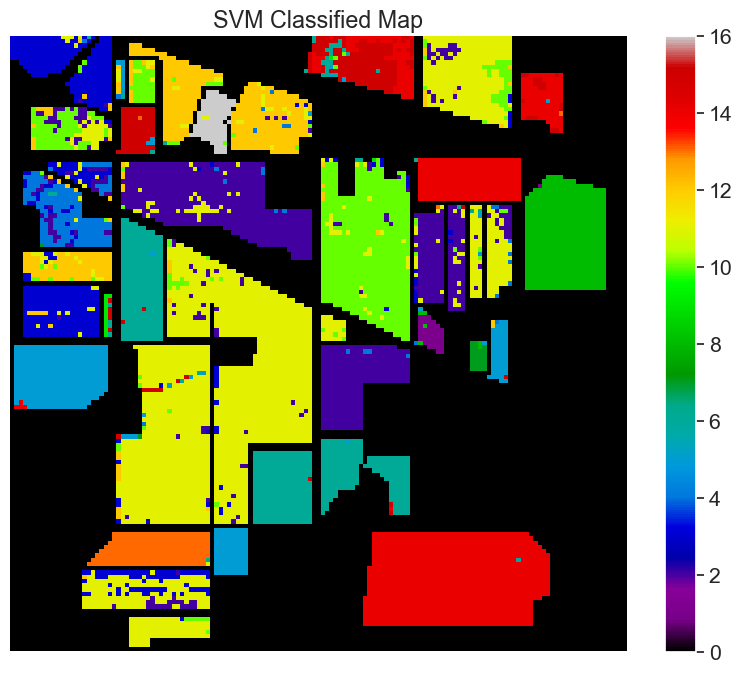

In [33]:
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.title('SVM Classified Map')
plt.axis('off')
#plt.savefig('IP_cmap.png')
plt.show()

## $$ Random\ Forest\ without\ PCA $$

A random forest classifier is made up of several decision trees.

The classifier is provided with training samples by the user with specified classes, from which the trees learn different characteristics of the class.

When classification is carried out, each tree casts a unit vote for the most probable class. The finaloutput for classification is chosen based on most of the votes

(-0.5, 895.5, 540.5, -0.5)

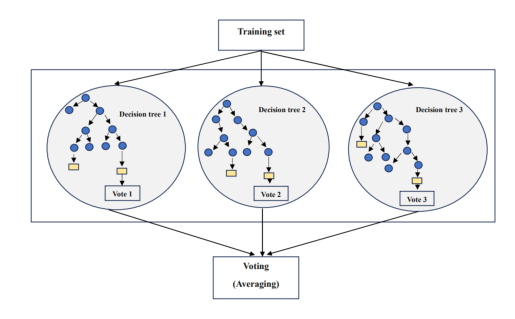

In [48]:
rf = Image.open('RF_image.png')
plt.imshow(rf)
plt.axis('off')

$$ Steps\ Involved $$

* Data Preparation
* Random Sampling
* Decision Tree Construction
* Feature Selection
* Voting for prediction
* Hyper parameter tuning


Random Forest Overall Accuracy %: 87.85365853658537 %


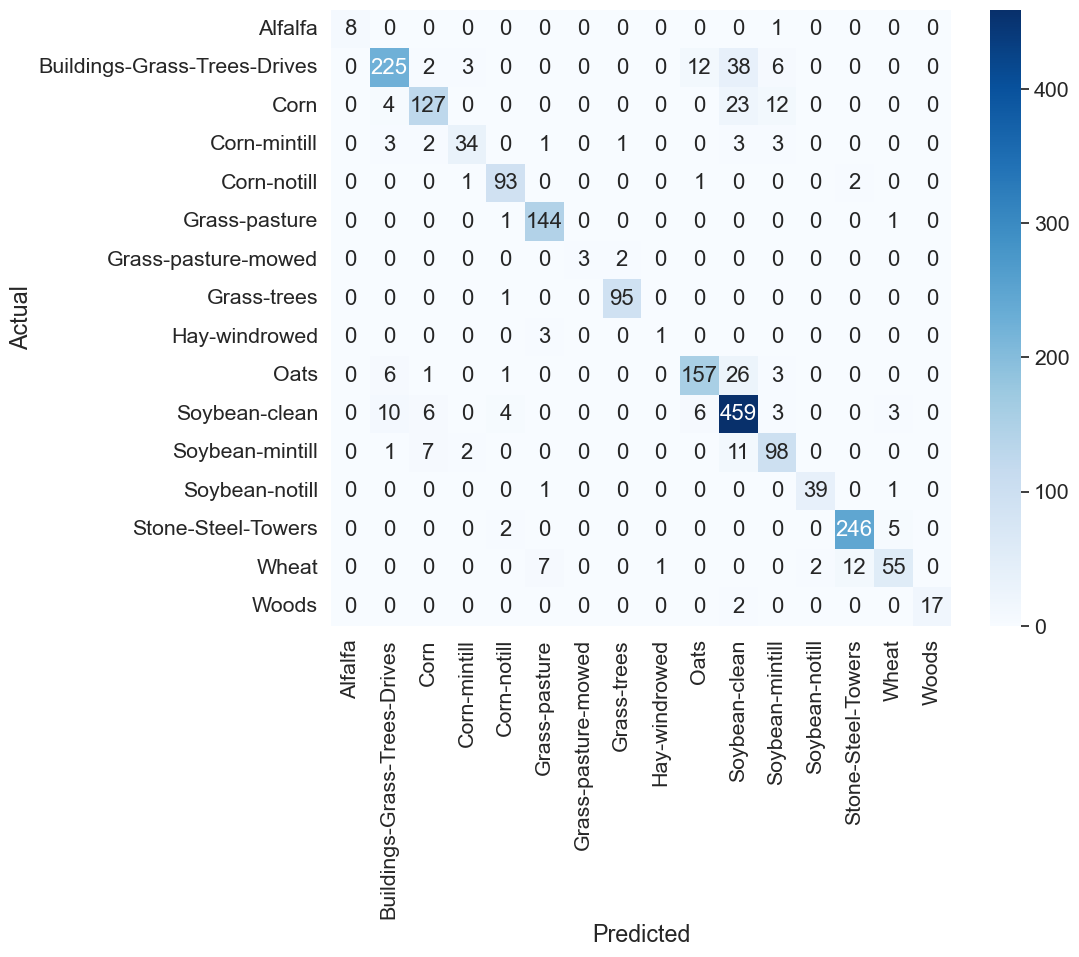

In [34]:
# Define and train the Random Forest classifier
rf_classifier1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier1.fit(X1_train, y1_train)

# Make predictions on the test set
rf_ypred1 = rf_classifier1.predict(X1_test)

# Generate confusion matrix
rf_data1 = confusion_matrix(y1_test, rf_ypred1)
rf_df_cm1 = pd.DataFrame(rf_data1, columns=np.unique(class_name), index=np.unique(class_name))
rf_df_cm1.index.name = 'Actual'
rf_df_cm1.columns.name = 'Predicted'

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(rf_df_cm1, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='d')

# Calculate overall accuracy
rf_overall_accuracy1 = accuracy_score(y1_test, rf_ypred1)
print("Random Forest Overall Accuracy %:", rf_overall_accuracy1*100, '%')

# Show the plot
plt.show()

In [35]:
print(classification_report(y1_test, rf_ypred1, target_names = class_name, zero_division=1))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.90      0.79      0.84       286
                Corn-mintill       0.88      0.77      0.82       166
                        Corn       0.85      0.72      0.78        47
               Grass-pasture       0.91      0.96      0.93        97
                 Grass-trees       0.92      0.99      0.95       146
         Grass-pasture-mowed       1.00      0.60      0.75         5
               Hay-windrowed       0.97      0.99      0.98        96
                        Oats       0.50      0.25      0.33         4
              Soybean-notill       0.89      0.81      0.85       194
             Soybean-mintill       0.82      0.93      0.87       491
               Soybean-clean       0.78      0.82      0.80       119
                       Wheat       0.95      0.95      0.95        41
                   

In [36]:
expected_shape = hsi.shape[:2]
r = []
# Iterate over each pixel in the DataFrame 'q'
for i in range(df.shape[0]):
    if df.iloc[i, -1] == 0:
        r.append(0)  # Append 0 for pixels labeled as 0
    else:
        # Make a prediction using the trained Random Forest classifier
        prediction = rf_classifier1.predict(df.iloc[i, :-1].values.reshape(1, -1))
        # Ensure prediction is a scalar value before appending
        if isinstance(prediction, (int, float)):
            r.append(prediction)
        else:
            r.append(prediction.item())  # Extract scalar value from array

# Now, check if the length of 'l' matches the expected shape
if len(r) != expected_shape[0] * expected_shape[1]:
    print("Error: Total number of elements in the list does not match the expected shape.")
else:
    # Reshape the list into the desired shape to create the class map
    rf_clmap1 = np.array(r).reshape(expected_shape).astype('float')

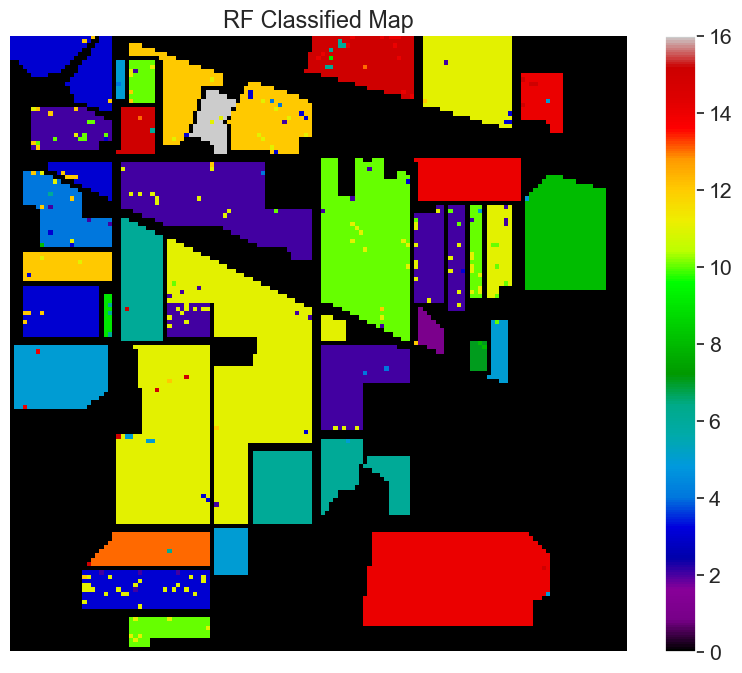

In [37]:
plt.figure(figsize=(10, 8))
plt.imshow(rf_clmap1, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('RF Classified Map')
#plt.savefig('IP_cmap.png')
plt.show()

# $$ SVM + PCA $$

In [38]:
#Removing the class from the PCA data
x = q[q['class'] != 0]

#Defing X and y values for training and testing the dataset
X = x.iloc[:, :-1].values
y = x.loc[:, 'class'].values 

print('Shape of X', X.shape, 'Shape of y', y.shape)

Shape of X (10249, 150) Shape of y (10249,)


In [39]:
#Spitting the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

#RGF kernel is used
svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)
svm.fit(X_train, y_train)
ypred = svm.predict(X_test)

Overall Accuracy %: 92.04878048780488 %


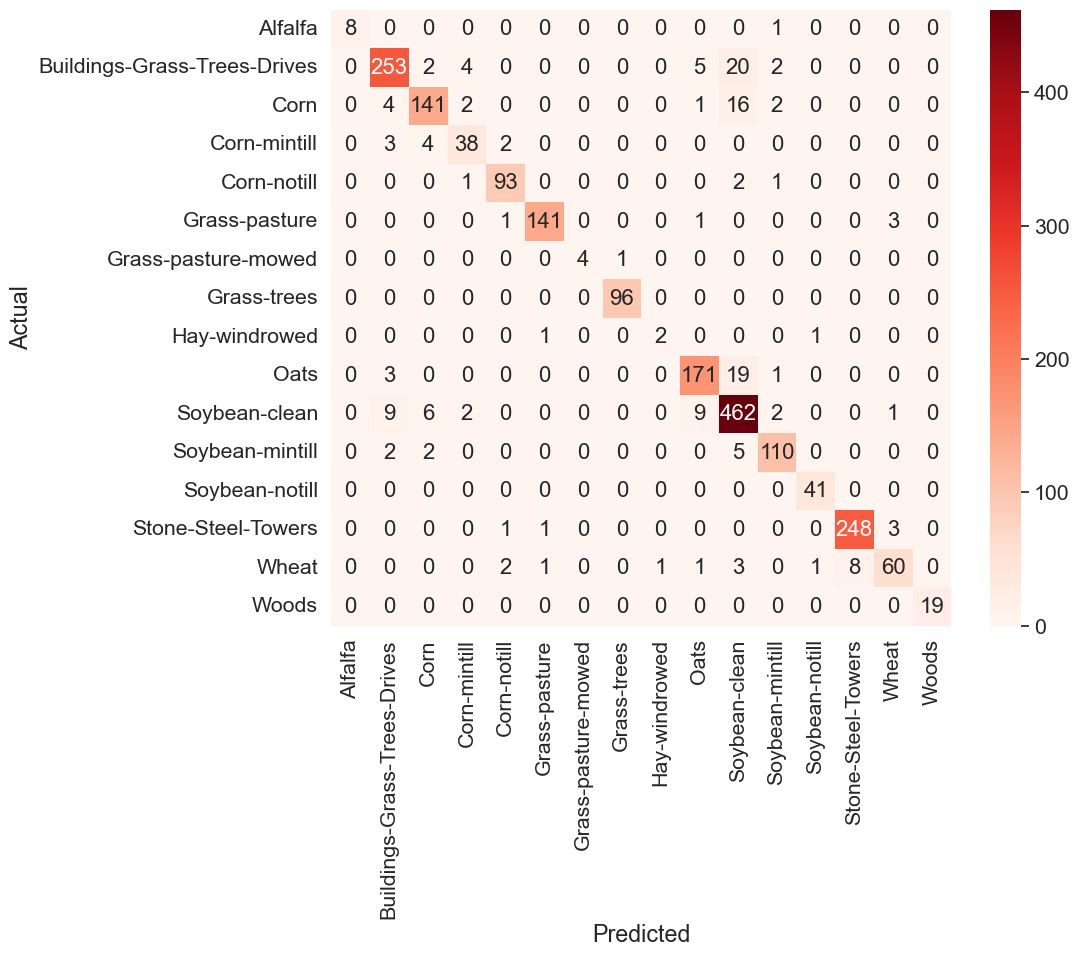

In [40]:
#Generating the Confusion Matrix
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(class_name), index = np.unique(class_name))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

#Plotting the confusion matrix
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, ypred)
print("Overall Accuracy %:", overall_accuracy*100, '%')

# Show the plot
plt.show()
#plt.savefig('cmap.png', dpi=300)

## Classification report of SVM`

In [41]:
print(classification_report(y_test, ypred, target_names = class_name))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.92      0.88      0.90       286
                Corn-mintill       0.91      0.85      0.88       166
                        Corn       0.81      0.81      0.81        47
               Grass-pasture       0.94      0.96      0.95        97
                 Grass-trees       0.98      0.97      0.97       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.67      0.50      0.57         4
              Soybean-notill       0.91      0.88      0.90       194
             Soybean-mintill       0.88      0.94      0.91       491
               Soybean-clean       0.92      0.92      0.92       119
                       Wheat       0.95      1.00      0.98        41
                   

## Plotting the Classified Map of SVM

In [42]:
expected_shape = hsi.shape[:2]
l = []
for i in range(q.shape[0]):
    if q.iloc[i, -1] == 0:
        l.append(0)
    else:
        prediction = svm.predict(q.iloc[i, :-1].values.reshape(1, -1))
        # Ensure prediction is a scalar value before appending
        if isinstance(prediction, (int, float)):
            l.append(prediction)
        else:
            l.append(prediction.item())  # Extract scalar value from array

# Now, check if the length of l matches the expected shape
if len(l) != expected_shape[0] * expected_shape[1]:
    print("Error: Total number of elements in the list does not match the expected shape.")
else:
    # Reshape the list into the desired shape
    clmap = np.array(l).reshape(expected_shape).astype('float')

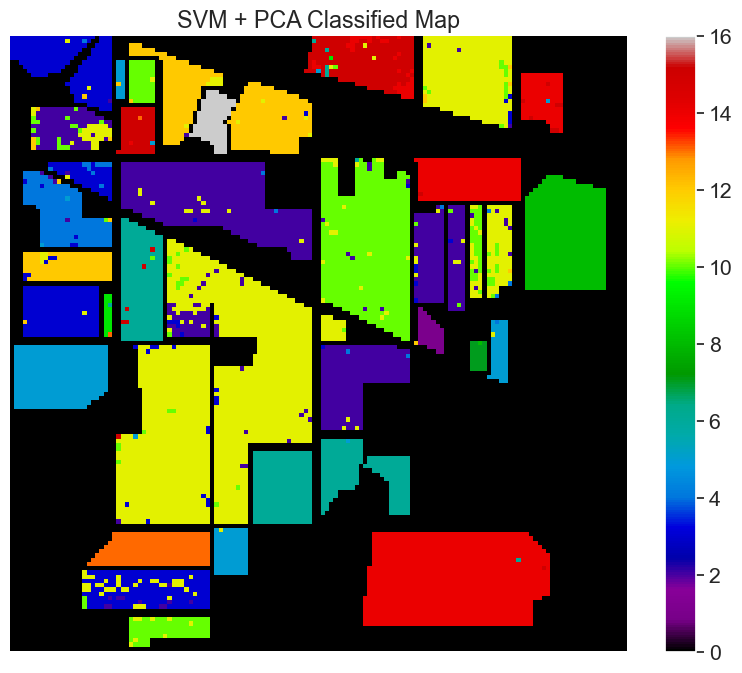

In [43]:
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.title('SVM + PCA Classified Map')
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()

# $$RF + PCA $$

Random Forest Overall Accuracy %: 81.5609756097561 %


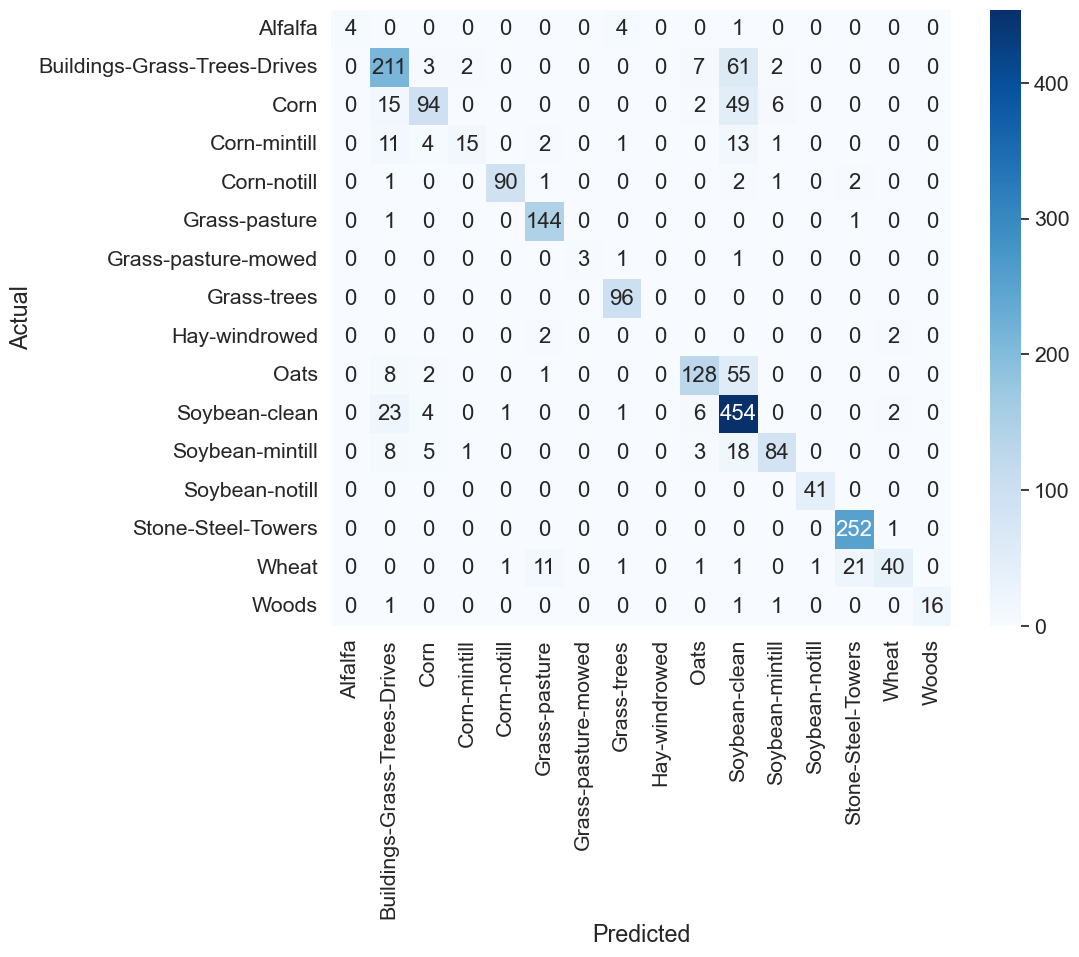

In [44]:
# Define and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
rf_ypred = rf_classifier.predict(X_test)

# Generate confusion matrix
rf_data = confusion_matrix(y_test, rf_ypred)
rf_df_cm = pd.DataFrame(rf_data, columns=np.unique(class_name), index=np.unique(class_name))
rf_df_cm.index.name = 'Actual'
rf_df_cm.columns.name = 'Predicted'

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sn.set(font_scale=1.4)  # for label size
sn.heatmap(rf_df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='d')

# Calculate overall accuracy
rf_overall_accuracy = accuracy_score(y_test, rf_ypred)
print("Random Forest Overall Accuracy %:", rf_overall_accuracy*100, '%')

# Show the plot
plt.show()


## Classification Report of RF

In [45]:
print(classification_report(y_test, rf_ypred, target_names = class_name, zero_division=1))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.44      0.62         9
                 Corn-notill       0.76      0.74      0.75       286
                Corn-mintill       0.84      0.57      0.68       166
                        Corn       0.83      0.32      0.46        47
               Grass-pasture       0.98      0.93      0.95        97
                 Grass-trees       0.89      0.99      0.94       146
         Grass-pasture-mowed       1.00      0.60      0.75         5
               Hay-windrowed       0.92      1.00      0.96        96
                        Oats       1.00      0.00      0.00         4
              Soybean-notill       0.87      0.66      0.75       194
             Soybean-mintill       0.69      0.92      0.79       491
               Soybean-clean       0.88      0.71      0.79       119
                       Wheat       0.98      1.00      0.99        41
                   

## Plotting Classified map of RF

In [46]:
expected_shape = hsi.shape[:2]
m = []
# Iterate over each pixel in the DataFrame 'q'
for i in range(q.shape[0]):
    if q.iloc[i, -1] == 0:
        m.append(0)  # Append 0 for pixels labeled as 0
    else:
        # Make a prediction using the trained Random Forest classifier
        prediction = rf_classifier.predict(q.iloc[i, :-1].values.reshape(1, -1))
        # Ensure prediction is a scalar value before appending
        if isinstance(prediction, (int, float)):
            m.append(prediction)
        else:
            m.append(prediction.item())  # Extract scalar value from array

# Now, check if the length of 'l' matches the expected shape
if len(m) != expected_shape[0] * expected_shape[1]:
    print("Error: Total number of elements in the list does not match the expected shape.")
else:
    # Reshape the list into the desired shape to create the class map
    rf_clmap = np.array(m).reshape(expected_shape).astype('float')
    # Now you can proceed with plotting or further analysis

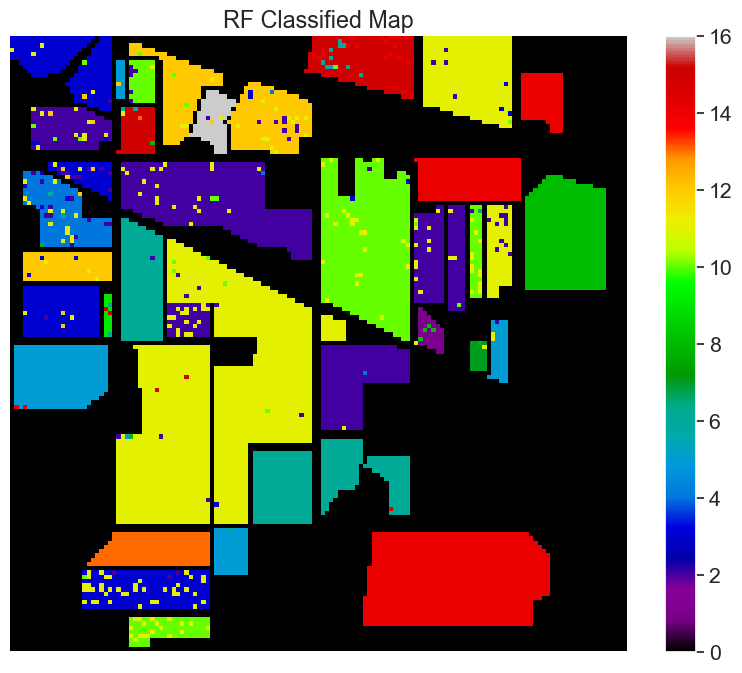

In [47]:
plt.figure(figsize=(10, 8))
plt.imshow(rf_clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.title('RF Classified Map')
plt.savefig('IP_cmap.png')
plt.show()

# $$ Future\ \ Work $$

### * Training a Deep Neural network for classification of Indian Pines dataset using pytorch

### * Comparision of models computed and evaluating the accuracy